C:\Users\devia\AppData\Local\Temp\ipykernel_25736\934399624.py:288: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\devia\AppData\Roaming\Python\Python313\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
C:\Users\devia\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\devia\AppData\Local\Temp\ipykernel_25736\934399624.py:317: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\devia\AppData\Roaming\Python\Python313\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_

Epoch 1/30 - Train Acc 0.4717 Loss 1.1331 | Val Acc 0.8392 Loss 0.7133
Epoch 2/30 - Train Acc 0.6075 Loss 0.5766 | Val Acc 0.9283 Loss 0.4064
Epoch 3/30 - Train Acc 0.5840 Loss 0.4091 | Val Acc 0.9538 Loss 0.3738
Epoch 4/30 - Train Acc 0.5133 Loss 0.4163 | Val Acc 0.9538 Loss 0.3861
Epoch 5/30 - Train Acc 0.5621 Loss 0.3612 | Val Acc 0.9713 Loss 0.3538
Epoch 6/30 - Train Acc 0.6563 Loss 0.3595 | Val Acc 0.9650 Loss 0.3557
Epoch 7/30 - Train Acc 0.6041 Loss 0.3307 | Val Acc 0.9634 Loss 0.3698
Epoch 8/30 - Train Acc 0.6075 Loss 0.3494 | Val Acc 0.9682 Loss 0.3663
Epoch 9/30 - Train Acc 0.6205 Loss 0.3194 | Val Acc 0.9729 Loss 0.3497
Epoch 10/30 - Train Acc 0.6396 Loss 0.2992 | Val Acc 0.9729 Loss 0.3555
Epoch 11/30 - Train Acc 0.6007 Loss 0.2904 | Val Acc 0.9745 Loss 0.3702
Epoch 12/30 - Train Acc 0.6065 Loss 0.2953 | Val Acc 0.9475 Loss 0.4006
Epoch 13/30 - Train Acc 0.7003 Loss 0.2537 | Val Acc 0.9554 Loss 0.3966
Epoch 14/30 - Train Acc 0.5928 Loss 0.2854 | Val Acc 0.9650 Loss 0.3924
E

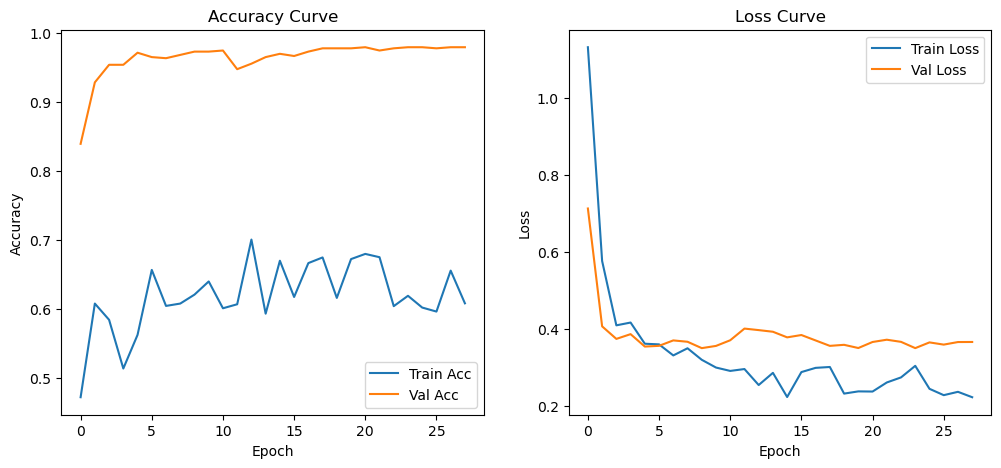


===== FINAL METRICS (MAFH-MNV3) =====
Accuracy     : 0.9792993630573248
Precision    : 0.9792993630573248
Recall       : 0.9792993630573248
F1-Score     : 0.9792993630573248
Specificity  : 0.993364294936809
MSE          : 0.0732484076433121
LogLoss      : 0.09482081820476676
AUC-ROC      : 0.9946213401604005

Classification Report:
                 precision    recall  f1-score   support

        Blight       0.97      0.97      0.97       172
   Common_Rust       0.99      0.99      0.99       196
Gray_Leaf_Spot       0.93      0.93      0.93        86
       Healthy       1.00      1.00      1.00       174

      accuracy                           0.98       628
     macro avg       0.97      0.97      0.97       628
  weighted avg       0.98      0.98      0.98       628



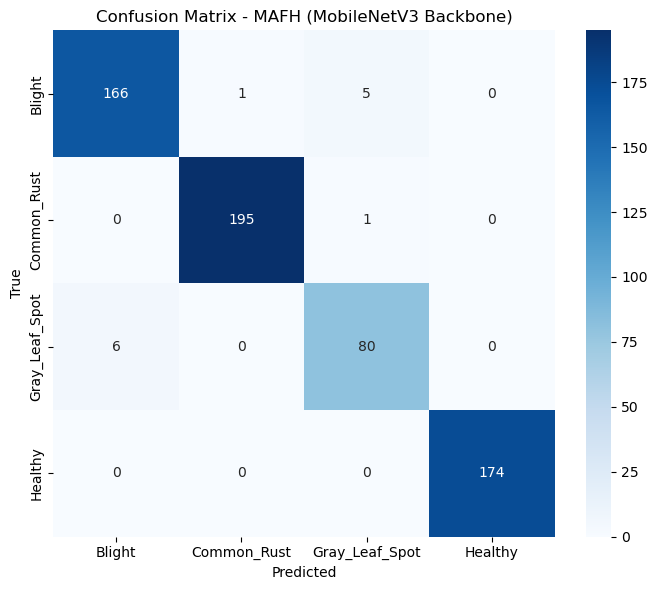

In [1]:
# ===========================================
# MAFH: MobileNetV3 + Attention + Fusion + Head
# for Maize Leaf Disease Detection (PyTorch)
# ===========================================
import os, math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms as T
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, mean_squared_error, log_loss, roc_auc_score,
    classification_report
)

# -----------------------
# Config
# -----------------------
DATA_DIR   = r"D:\maize_project\Dataset"   # expects train/ and val/
TRAIN_DIR  = os.path.join(DATA_DIR, "train")
VAL_DIR    = os.path.join(DATA_DIR, "val")
SAVE_PATH  = "mafh_mnv3_maize.pth"

IMG_SIZE   = 300        # MobileNetV3 handles 224–320 well; 300 often improves accuracy
BATCH_SIZE = 32
EPOCHS     = 30
PATIENCE   = 7
BASE_LR    = 3e-4
WEIGHT_DEC = 1e-4
LABEL_SMOOTH = 0.05     # label smoothing factor
USE_MIXUP  = True
MIXUP_ALPHA = 0.2
NUM_WORKERS = 2
SEED = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# Reproducibility
# -----------------------
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
set_seed()

# -----------------------
# Dataset & Transforms
# -----------------------
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_tf = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.6, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(p=0.1),
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.25, contrast=0.2, saturation=0.2, hue=0.02),
    T.RandomAutocontrast(p=0.2),
    T.ToTensor(),
    T.Normalize(mean, std),
])

val_tf = T.Compose([
    T.Resize(int(IMG_SIZE*1.15)), T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean, std),
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=val_tf)
NUM_CLASSES = len(train_ds.classes)

# Class-balance handling (optional but helpful for >98%)
def make_sampler(ds):
    targets = [y for _,y in ds.samples]
    class_count = np.bincount(targets)
    class_weights = 1.0 / np.maximum(class_count, 1)
    weights = class_weights[targets]
    return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=False,
    sampler=make_sampler(train_ds), num_workers=NUM_WORKERS, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
)

# -----------------------
# MixUp utilities
# -----------------------
def one_hot(labels, num_classes):
    y = torch.zeros((labels.size(0), num_classes), device=labels.device)
    y.scatter_(1, labels.view(-1,1), 1)
    return y

def mixup_data(x, y, alpha=MIXUP_ALPHA):
    if alpha <= 0:
        return x, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    mixed_x = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return mixed_x, (y_a, y_b), lam

def soft_ce(logits, soft_targets):
    log_probs = F.log_softmax(logits, dim=1)
    return -(soft_targets * log_probs).sum(dim=1).mean()

def loss_with_label_smoothing(logits, targets, smoothing=LABEL_SMOOTH, num_classes=NUM_CLASSES):
    with torch.no_grad():
        true_dist = torch.zeros_like(logits)
        true_dist.fill_(smoothing / (num_classes - 1))
        true_dist.scatter_(1, targets.unsqueeze(1), 1 - smoothing)
    return soft_ce(logits, true_dist)

# -----------------------
# Attention (CBAM)
# -----------------------
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
    def forward(self, x):
        b, c, h, w = x.size()
        avg_pool = F.adaptive_avg_pool2d(x, 1).view(b, c)
        max_pool = F.adaptive_max_pool2d(x, 1).view(b, c)
        out = self.mlp(avg_pool) + self.mlp(max_pool)
        scale = torch.sigmoid(out).view(b, c, 1, 1)
        return x * scale

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        attn = torch.sigmoid(self.conv(torch.cat([avg, mx], dim=1)))
        return x * attn

class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(channels, reduction)
        self.sa = SpatialAttention(kernel_size)
    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

# -----------------------
# MAFH Model
#   - MobileNetV3 backbone
#   - Multi-scale fusion (auto taps)
#   - CBAM attention
#   - Classifier head
# -----------------------
class MAFH_MobileNetV3(nn.Module):
    def __init__(self, num_classes, tap_ids=None, fuse_dim=128):
        super().__init__()
        m = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
        self.stem = nn.Sequential(m.features)   # nn.Sequential of blocks

        # choose tap points (indices) if not provided
        L = len(self.stem)
        if tap_ids is None:
            # take three progressively deeper layers
            tap_ids = [L//3, 2*L//3, L-1]
        self.tap_ids = sorted(set([max(0, min(L-1, t)) for t in tap_ids]))

        # lateral 1x1 to unify channels
        self.laterals = nn.ModuleList([nn.Conv2d(self._out_ch(i), fuse_dim, 1, bias=False)
                                       for i in self.tap_ids])
        self.bn_lats  = nn.ModuleList([nn.BatchNorm2d(fuse_dim) for _ in self.tap_ids])

        # fusion conv after concat
        self.fuse = nn.Sequential(
            nn.Conv2d(fuse_dim*len(self.tap_ids), fuse_dim*2, 3, padding=1, bias=False),
            nn.BatchNorm2d(fuse_dim*2),
            nn.SiLU(inplace=True)
        )

        # attention
        self.attn = CBAM(fuse_dim*2, reduction=8)

        # head
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(fuse_dim*2, num_classes)

    def _out_ch(self, idx):
        # run a dummy tensor once to read channels of each block’s output
        if not hasattr(self, "_probe"):
            self._probe = {}
            with torch.no_grad():
                x = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE)
                for i, layer in enumerate(self.stem):
                    x = layer(x)
                    self._probe[i] = x.shape[1]
        return self._probe[idx]

    def forward(self, x):
        feats = []
        x_curr = x
        taps = []
        for i, layer in enumerate(self.stem):
            x_curr = layer(x_curr)
            if i in self.tap_ids:
                taps.append(x_curr)

        # unify channels
        ups = []
        # upsample all to the largest spatial among taps
        H = max(t.shape[2] for t in taps)
        W = max(t.shape[3] for t in taps)
        for t, lat, bn in zip(taps, self.laterals, self.bn_lats):
            z = bn(lat(t))
            if z.shape[2] != H or z.shape[3] != W:
                z = F.interpolate(z, size=(H, W), mode='bilinear', align_corners=False)
            ups.append(z)

        fused = torch.cat(ups, dim=1)          # [B, fuse_dim*len(taps), H, W]
        fused = self.fuse(fused)               # [B, 2*fuse_dim, H, W]
        fused = self.attn(fused)               # attention-refined
        g = self.pool(fused).flatten(1)        # GAP
        g = self.dropout(g)
        out = self.fc(g)
        return out

# -----------------------
# Utilities
# -----------------------
def cosine_with_warmup(optimizer, total_steps, warmup_steps=0):
    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        progress = (step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def evaluate(net, loader, criterion):
    net.eval(); correct=total=0; loss_sum=0
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
            logits = net(xb)
            loss = criterion(logits, yb).item()
            preds = logits.argmax(1)
            correct += (preds==yb).sum().item()
            total   += yb.size(0)
            loss_sum += loss * yb.size(0)
    return correct/total, loss_sum/total

def specificity_multiclass(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    specs = []
    for i in range(num_classes):
        TP = cm[i,i]
        FN = cm[i,:].sum() - TP
        FP = cm[:,i].sum() - TP
        TN = cm.sum() - (TP+FN+FP)
        denom = TN + FP
        specs.append(TN/denom if denom>0 else np.nan)
    return np.nanmean(specs), cm

# -----------------------
# Build model, optimizer, scheduler
# -----------------------
model = MAFH_MobileNetV3(NUM_CLASSES).to(DEVICE)

# Separate head parameters for potential higher LR (optional)
optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DEC)

scaler = GradScaler()

num_steps_per_epoch = math.ceil(len(train_loader.dataset)/BATCH_SIZE)
total_steps = EPOCHS * num_steps_per_epoch
scheduler = cosine_with_warmup(optimizer, total_steps, warmup_steps=int(0.1*total_steps))

# label smoothing criterion wrapper
def criterion_fn(logits, targets):
    return loss_with_label_smoothing(logits, targets, smoothing=LABEL_SMOOTH, num_classes=NUM_CLASSES)

# -----------------------
# Training
# -----------------------
train_acc_h, val_acc_h, train_loss_h, val_loss_h = [],[],[],[]
best_val = 0.0
patience = 0
global_step = 0

for epoch in range(1, EPOCHS+1):
    model.train()
    run_loss = 0.0; correct = 0; total = 0

    for xb, yb in train_loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        if USE_MIXUP:
            xb_mix, (ya, yb2), lam = mixup_data(xb, yb, MIXUP_ALPHA)
            with autocast():
                logits = model(xb_mix)
                # soft targets for mixup + smoothing
                y_soft = lam * one_hot(ya, NUM_CLASSES) + (1 - lam) * one_hot(yb2, NUM_CLASSES)
                loss = soft_ce(logits, y_soft)
        else:
            with autocast():
                logits = model(xb)
                loss = criterion_fn(logits, yb)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        global_step += 1

        run_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        # for accuracy we can still compare to one of the labels in mixup (approx)
        hard_targets = yb if not USE_MIXUP else ya
        correct += (preds == hard_targets).sum().item()
        total += xb.size(0)

    train_loss = run_loss / total
    train_acc  = correct / total

    # validation (no mixup)
    model.eval(); v_correct=v_total=0; v_loss_sum=0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            with autocast():
                logits = model(xb)
                v_loss = criterion_fn(logits, yb).item()
            v_loss_sum += v_loss * yb.size(0)
            v_preds = logits.argmax(1)
            v_correct += (v_preds==yb).sum().item()
            v_total += yb.size(0)

    val_loss = v_loss_sum / v_total
    val_acc  = v_correct / v_total

    train_acc_h.append(train_acc); val_acc_h.append(val_acc)
    train_loss_h.append(train_loss); val_loss_h.append(val_loss)

    print(f"Epoch {epoch}/{EPOCHS} - Train Acc {train_acc:.4f} Loss {train_loss:.4f} | Val Acc {val_acc:.4f} Loss {val_loss:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        patience = 0
        torch.save(model.state_dict(), SAVE_PATH)
    else:
        patience += 1
        if patience >= PATIENCE:
            print("Early stopping.")
            break

print("Best Val Acc:", best_val)

# -----------------------
# Curves
# -----------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_acc_h, label='Train Acc'); plt.plot(val_acc_h, label='Val Acc')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curve"); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_loss_h, label='Train Loss'); plt.plot(val_loss_h, label='Val Loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve"); plt.legend()
plt.show()

# -----------------------
# Final Evaluation (best model)
# -----------------------
model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))
model.eval()

y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(1)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true); y_pred = np.array(y_pred); y_prob = np.array(y_prob)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted")
rec  = recall_score(y_true, y_pred, average="weighted")
f1   = f1_score(y_true, y_pred, average="weighted")
spec, cm = specificity_multiclass(y_true, y_pred, NUM_CLASSES)
mse  = mean_squared_error(y_true, y_pred)
ll   = log_loss(y_true, y_prob)
try:
    auc = roc_auc_score(y_true, y_prob, multi_class="ovr")
except:
    auc = None

print("\n===== FINAL METRICS (MAFH-MNV3) =====")
print("Accuracy     :", acc)
print("Precision    :", prec)
print("Recall       :", rec)
print("F1-Score     :", f1)
print("Specificity  :", spec)
print("MSE          :", mse)
print("LogLoss      :", ll)
print("AUC-ROC      :", auc)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=val_ds.classes))

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=val_ds.classes, yticklabels=val_ds.classes)
plt.title("Confusion Matrix - MAFH (MobileNetV3 Backbone)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()
